In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

In [6]:
print(type(train_data))

<class 'dict'>


In [ ]:
X_train, y_train = train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [8]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels '
assert(X_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels '
assert(X_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels '
assert(X_train.shape[1:] == (32, 32, 3)), 'The dimensions of the image are not 32 x 32 x 3'
assert(X_val.shape[1:] == (32, 32, 3)), 'The dimensions of the image are not 32 x 32 x 3'
assert(X_test.shape[1:] == (32, 32, 3)), 'The dimensions of the image are not 32 x 32 x 3'

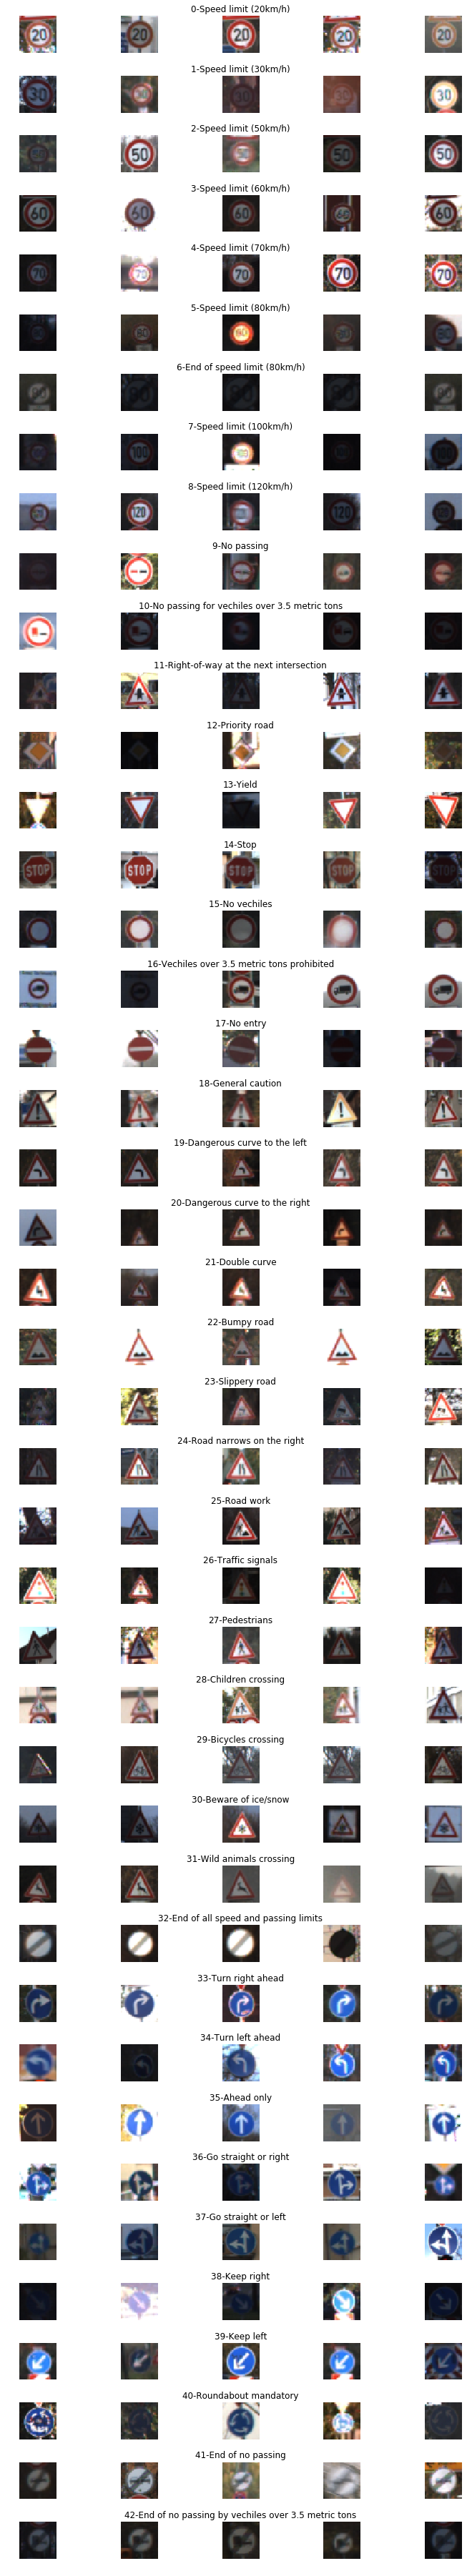

In [10]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(10,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + '-' + row['SignName'])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


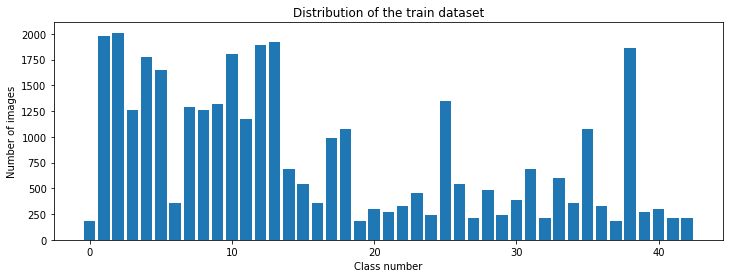

In [11]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
41


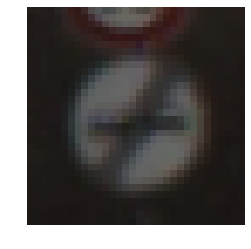

In [12]:
import cv2

plt.imshow(X_train[7])
plt.axis('off')
print(X_train[7].shape)
print(y_train[7])

(32, 32)


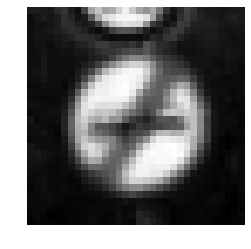

In [13]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[7])
plt.imshow(img, cmap='gray')
plt.axis('off')
print(img.shape)

(32, 32)


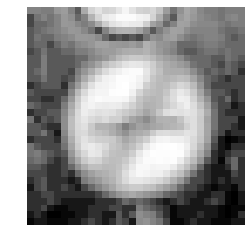

In [14]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img, cmap='gray')
plt.axis("off")
print(img.shape)

In [ ]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


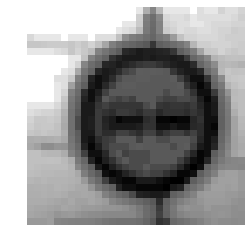

In [16]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap='gray')
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [ ]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [20]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(34799, 43)
(4410, 43)
(12630, 43)


In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [22]:
model = modified_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 30)          0        

In [23]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 34799 samples, validate on 4410 samples
Epoch 1/10





34799/34799 [==============================] - 8s 243us/step - loss: 2.0559 - acc: 0.4389 - val_loss: 0.8089 - val_acc: 0.8147
Epoch 2/10
34799/34799 [==============================] - 5s 146us/step - loss: 0.5751 - acc: 0.8220 - val_loss: 0.3924 - val_acc: 0.9104
Epoch 3/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.3283 - acc: 0.8980 - val_loss: 0.2657 - val_acc: 0.9347
Epoch 4/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.2298 - acc: 0.9275 - val_loss: 0.2115 - val_acc: 0.9517
Epoch 5/10
34799/34799 [==============================] - 5s 148us/step - loss: 0.1689 - acc: 0.9477 - val_loss: 0.1623 - val_acc: 0.9576
Epoch 6/10
34799/34799 [==============================] - 5s 147us/step - loss: 0.1327 - acc: 0.9583 - val_loss: 0.1283 - val_acc: 0.9646
Epoch 7/10
34799/3479

Text(0.5, 0, 'epoch')

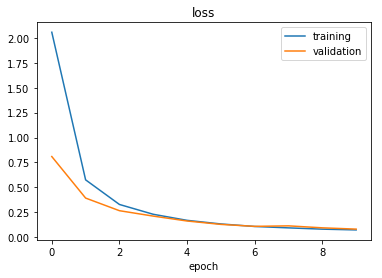

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

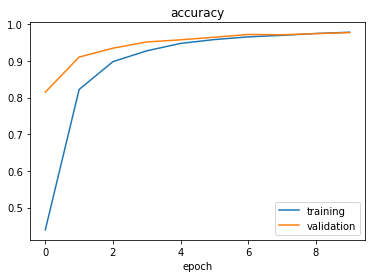

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')
plt.xlabel('epoch')

In [26]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

12630/12630 [==============================] - 2s 137us/step
Test Score: 0.16642148962284212
Test Accuracy: 0.9517022961392255


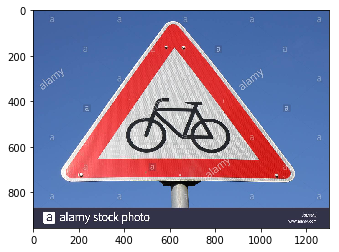

In [27]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


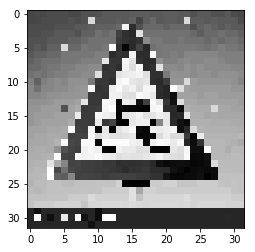

In [28]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
img = img.reshape(1, 32, 32, 1)

In [30]:
print("predicted sign: "+ str(model.predict_classes(img)))

predicted sign: [31]
